In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import re
import time
from datetime import timedelta
from openpyxl import Workbook, load_workbook
import os
import warnings
import itertools

# Suppress legend-related warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
naming = '-' ###IMPORTANT#### used for degree node naming and checking inside algorithm 

def create_graph(edges):
    # Create an undirected graph
    graph = nx.Graph()            
        
    # Add edges to the graph
    # You can customize this part based on your specific graph or load it from external data
    graph.add_edges_from(edges)

    return graph

def create_neg_graph(g):
    # Create an undirected graph
    graph = nx.Graph()  
    
    
    edges = []
    
    for node in g:
        for nei, sign in g[node]:
            if sign != 1:
                edge = (node, nei)
                edges.append(edge)
        
    # Add edges to the graph
    # You can customize this part based on your specific graph or load it from external data
    graph.add_edges_from(edges)

    return graph


def calculate_delta(graph, upper_bounds):
    delta_values = {}
    # Calculate delta for each vertex
    for node in graph.nodes():
        degree = graph.degree(node)
        upper_bound = upper_bounds[node]
        delta = degree - upper_bound
        delta_values[node] = delta

    return delta_values

def create_bipartite_graph(node, delta, degree, combined_bipartite_edges, graph_dict):

    bipartite_graph = nx.Graph()

    # Add nodes to the first class
    # range starts from node value to node+delta value
    
    delta_node_names = []
    
    
    for i in range(0, delta):
        if i != 0:
            delta_node_name = str(node) + "." + str(i)
            delta_node_names.append(delta_node_name)
        else:
            delta_node_names.append(node)
    
    bipartite_graph.add_nodes_from(delta_node_names, bipartite=0)


    # Add nodes to the second class
    bipartite_graph.add_nodes_from(graph_dict[str(node)], bipartite=1)

    # Add edges between nodes of opposite classes
    bipartite_graph.add_edges_from([(delta_node, degree_node) for delta_node in delta_node_names for degree_node in graph_dict[str(node)]])
    
    #getting edges from eact subgraphs
    for primary_edge, secondary_edge in bipartite_graph.edges():
        edge = (primary_edge, (str(node) +naming+ str(secondary_edge)))
            
        #appending edges
        combined_bipartite_edges.append(edge)
        
   ################# The below is explaination of combined bipartite graph namings #####################

    ### Namings
    # Delta node represented with and without "." (eg: "1.2", "1.3", "1.4", 1)
    # bipartited-degree-nodes represented with "," (eg: "1-2" "1-3" "1-4")
    
    # (1.2, 1-2) --> delta node 1.2 connects with degree node 1-2
    # (1-2 , 1) --> degree node 1-2 connects with delta node 1
    # (1-2 , 2-1) --> Node 1 bipartited-degree-nodes connects with Node 2 bipartited-degree-nodes

    # in bipartited graph we connect delta node with degree node
    # for combining bipartited graph with other bipartited graph we connect degree node 
    # with degree node (eg: "3,1" connect with "1,3")
        
        
    return (bipartite_graph, node)


def display_all_bipartite_graphs(bipartite_graphs, n):
    
    plt.figure(figsize=(12, 8))
    
    for i, (bipartite_graph, node) in enumerate(bipartite_graphs):
        plt.subplot(int(len(n)/2), 3, i + 1)
        pos = nx.spring_layout(bipartite_graph)
        nx.draw(bipartite_graph, pos, with_labels=True, font_weight='bold', node_color=['skyblue' if bipartite == 0 else 'lightcoral' for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()], node_size=500, edgecolors='black', linewidths=1.0)
        plt.title(f"Bipartite Graph for Node {node}")

    plt.show()

In [3]:
def read_signed_graph_from_file(file_path):
    graph_dict = {}
    
    original_graph = []
    
    with open(file_path, 'r') as file:
        for line in file:
            source, target, weight = map(int, line.strip().split())
            original_graph.append((source, target, {"sign": weight}))
            
            if source not in graph_dict:
                graph_dict[source] = []
            if target not in graph_dict:
                graph_dict[target] = []
            graph_dict[source].append((target, weight))
            graph_dict[target].append((source, weight))
    return graph_dict, original_graph

def flipping_graph_sign(original_graph, flipping_edges):
    
    graph = nx.Graph() 
    
    flipping = original_graph.copy()
    
    for source, target, sign in flipping:
        for flip_source, flip_target in flipping_edges:
            if source == flip_source and target == flip_target or target == flip_source and source == flip_target:
                sign["sign"] = 1
            
    graph.add_edges_from(flipping)

    return graph    
    

def finding_positive_and_negative_neighbours(g):
    
    all_pos_connections = {}
    all_neg_connections = {}
    
    for node in g:
        pos_nei = []
        neg_nei = []
        
        for nei, sign in g[node]:
            if sign == 1:
                pos_nei.append(nei)
            elif sign == -1:
                neg_nei.append(nei)
            
        all_pos_connections[node] = {"neighbour": pos_nei}
        all_neg_connections[node] = {"neighbour": neg_nei}
        
        
        all_pos_connections[node]['total_count'] = len(pos_nei)
        all_neg_connections[node]['total_count'] = len(neg_nei)
        
        
        all_pos_connections[node]['inside_d_count'] = 0
        all_neg_connections[node]['inside_d_count'] = 0
        
        all_pos_connections[node]['inside_d_neighbour'] = []
        all_neg_connections[node]['inside_d_neighbour'] = []
    
#     for node in g:
#         all_pos_connections[node]['total_count'] = len(all_pos_connections[node]['neighbour'])
#         all_pos_connections[node]['inside_d_count'] = 0
        
#         all_neg_connections[node]['total_count'] = len(all_neg_connections[node]['neighbour'])
#         all_neg_connections[node]['inside_d_count'] = 0
    
    
    return all_pos_connections, all_neg_connections
            
    
def pos_neg_inside_d_or_not(d, all_positive, all_negative):
    all_pos = all_positive.copy()
    all_neg = all_negative.copy()
    b = []
    
    for node in d:
        to_check = [elem for elem in d if elem != node]
        
        if node in all_pos and 'neighbour' in all_pos[node] and node in all_neg and 'neighbour' in all_neg[node]:
        
            for checking_value in to_check:
            
                if checking_value in all_pos[node]['neighbour']:
                    all_pos[node]['total_count'] -= 1
                    all_pos[node]['inside_d_count'] += 1
                    all_pos[node]['neighbour'].remove(checking_value)
                    all_pos[node]['inside_d_neighbour'].append(checking_value) 
                    
                elif checking_value in all_neg[node]['neighbour']:
                    all_neg[node]['total_count'] -= 1
                    all_neg[node]['inside_d_count'] += 1
                    all_neg[node]['neighbour'].remove(checking_value)
                    all_neg[node]['inside_d_neighbour'].append(checking_value)
                
            node_max_neg_count = 0
            node_max_neg_count = max(all_neg[node]['total_count'], all_neg[node]['inside_d_count'])
        
            if (all_pos[node]['inside_d_count'] + 1) < node_max_neg_count:
                b.append(node)
    
    return b, all_pos, all_neg


def check_upper_bound(graph, b_value, all_pos, all_neg):
    upper_bound = {}
    
    for node in graph:
        if node not in b_value:
            upper_bound[node] = 0
        else:
            b1 = all_neg[node]['total_count'] - all_pos[node]['inside_d_count'] - 1
            
            b2 = math.ceil((all_neg[node]['inside_d_count'] - all_pos[node]['inside_d_count'] - 1) / 2)
            
            upper_bound[node] = max(b1, b2)
            
    return upper_bound

def find_max_edge(matching):
    
    edges_check = []
    
    for node, nei in matching:  
        vertex1 = str(node).split(naming)
        vertex2 = str(nei).split(naming)[::-1]
        
        if len(vertex1) == len(vertex2):
            if vertex1[0] == vertex2[0] and vertex1[1] == vertex2[1]:
                if int(vertex1[0]) < int(vertex1[1]):
                    edges_check.append(( int(vertex1[0]), int(vertex1[1])))
                else:
                    edges_check.append(( int(vertex1[1]), int(vertex1[0])))
                    
    unique_edges = list(set(edges_check))
                    
    return unique_edges
    
    
def finding_bipratie_graph_connecting_edges(combined_bipartite_edges):
    connecting = []
    rev_nodes = []

    # Iterate through the list to build mappings
    for node1, node2 in combined_bipartite_edges: 
        
        rev_node = (str(node2)[::-1])
        edge_set = (node2, rev_node)
        if rev_node not in rev_nodes:
            if edge_set not in connecting:
                connecting.append((node2, rev_node))
                rev_nodes.append(rev_node)
                rev_nodes.append(node2)
                
    return connecting
    
### Reduction part
    
def form_s(neg_neighbors_in_d, neg_neighbors_out_d, z, node):
    
    nei_in_d = []
    nei_out_d = []
    
    formed_s = []
    
    for nei in neg_neighbors_in_d:
        nei_in_d.append((node, nei))
        
        
    for nei in neg_neighbors_out_d:
        nei_out_d.append((node, nei))
        
    
    for values in nei_in_d:
        formed_s.append(values)
    
    for idx, values in enumerate(nei_out_d):
        if idx < z:
            formed_s.append(nei_out_d[idx])
     
    return formed_s, nei_in_d, nei_out_d
    

def check_reduction(all_pos, all_neg, node):
    
    z =  all_neg[node]['total_count'] - all_pos[node]['inside_d_count'] - all_neg[node]['inside_d_count'] - 1
      
    s, nei_in_d, nei_out_d = [], [], []
    
    if z >= 0:
        s, nei_in_d, nei_out_d = form_s(all_neg[node]['inside_d_neighbour'], 
                    all_neg[node]['neighbour'],
                    z, node )
    return s, nei_in_d, nei_out_d


def visualize_all_graphs(G, udcs_matching_edges, is_udcs_checked, flipping_matching_edges, flipped_graph, can_show):

    steps = 1
    graph = nx.spring_layout(G)
    
    graph2 = nx.spring_layout(flipped_graph)
    
    # Visualize the graph with positive edges in green and negative edges in red
    pos_edges = [(u, v) for u, v, sign in G.edges(data="sign") if sign == 1]
    neg_edges = [(u, v) for u, v, sign in G.edges(data="sign") if sign == -1]
    
    
    plt.figure(figsize=(12,8))
    
    # Create the first subplot
    plt.subplot(2, 2, 1)

     # Plot data in the second subplot (axes[0])
    nx.draw_networkx_nodes(G, graph,  node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0)
    nx.draw_networkx_edges(G, graph, edgelist=pos_edges, edge_color="g")
    nx.draw_networkx_edges(G, graph, edgelist=neg_edges, edge_color="r")
    nx.draw_networkx_labels(G, graph, font_size=12, font_color='black')
   
    plt.title(f"Fig.{steps}")
    steps += 1 
    
    if is_udcs_checked:
    
        # Create the first subplot
        plt.subplot(2, 2, 2)

        nx.draw_networkx_nodes(G, graph, node_color="skyblue", node_size=300, edgecolors='black', linewidths=1.0)
        nx.draw_networkx_edges(G, graph, edgelist=udcs_matching_edges, edge_color='blue', width=2.0)
        nx.draw_networkx_labels(G, graph, font_size=12, font_color='black')

        plt.title(f"Fig.{steps}")
        steps += 1 
    

    # Create the second subplot
    plt.subplot(2, 2, 3)
    
    nx.draw_networkx_nodes(G, graph, node_color="skyblue", node_size=300, edgecolors='black', linewidths=1.0)
    nx.draw_networkx_edges(G, graph, edgelist=flipping_matching_edges, edge_color='blue', width=2.0)
    nx.draw_networkx_labels(G, graph, font_size=12, font_color='black')
    
    plt.title(f"Fig.{steps}")
    steps += 1 
    
    if can_show:
        
    
        # Create the second subplot
        plt.subplot(2, 2, 4)
    
        # Visualize the graph with positive edges in green and negative edges in red
        pos_edges2 = [(u, v) for u, v, sign in flipped_graph.edges(data="sign") if sign == 1]
        neg_edges2 = [(u, v) for u, v, sign in flipped_graph.edges(data="sign") if sign == -1]
    
         # Plot data in the second subplot (axes[0])
        nx.draw_networkx_nodes(flipped_graph, graph2,  node_color="skyblue", node_size=500, edgecolors='black', linewidths=1.0)
        nx.draw_networkx_edges(flipped_graph, graph2, edgelist=pos_edges2, edge_color="g")
        nx.draw_networkx_edges(flipped_graph, graph2, edgelist=neg_edges2, edge_color="r")
        nx.draw_networkx_labels(flipped_graph, graph2, font_size=12, font_color='black')
    
        plt.title(f"Fig.{steps}")

#     plt.title(("Required Flips to form Defensive Allaince")
    
#     plt.plot([0], color='green', label='Positive Connection')
#     plt.plot([0], color='red', label='Negative Connection')
#     plt.plot([0], color='blue', label='Negative Connection')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    plt.show()
    

    
def reduction(udcs_matching_edges, all_positive_after_check, all_negative_after_check, upper_bounds_dict, b):
    
    deg_in_udcs_matching_edges = {}

    for node in b:
        deg_in_udcs_matching_edges[node] = 0
    
        for edge in udcs_matching_edges:
            vertex1, vertex2 = edge  # Unpack the edge tuple
            if node == vertex1 or node == vertex2:
                deg_in_udcs_matching_edges[node] += 1
    
            
    flipping_matching_edges = udcs_matching_edges.copy()

    for node in b:

        if deg_in_udcs_matching_edges[node] < upper_bounds_dict[node]:
        
            s, nei_in_d, nei_out_d = check_reduction(all_positive_after_check, all_negative_after_check, node)
            
            inequality_count = upper_bounds_dict[node] - deg_in_udcs_matching_edges[node]
            
            ## prioritizing edges to flip inside d. 
            idx = 0
            while inequality_count > 0:
                if idx > len(s) - 1:
                    break
                    
                if s[idx] not in udcs_matching_edges:
                    if s[idx] in nei_in_d:
                        if s[idx] not in flipping_matching_edges: 
                            flipping_matching_edges.append(s[idx])
                            inequality_count -= 1 
                idx += 1
                
            ## edges to flip 
            idx = 0 
            while inequality_count > 0:
                if idx > len(s) - 1:
                    break
                if s[idx] not in udcs_matching_edges:
                    if s[idx] not in flipping_matching_edges: 
                        flipping_matching_edges.append(s[idx])
                        inequality_count -= 1
                idx += 1
                
    return set(flipping_matching_edges)
    
def add_entries_to_excel(entries, filepath):
    # If the file exists, load the existing workbook; otherwise, create a new workbook
    if os.path.exists(filepath):
        wb = load_workbook(filepath)
    else:
        wb = Workbook()
    
    # Select the active worksheet
    ws = wb.active
    
    # If the file is newly created, add column headers
    if not os.path.exists(filepath):
        ws.append(['Number of Vertex', 'Time without Visualization', 'Time with Visualization', 'K count', 'Set D'])
    
    # Add entries
    ws.append(entries)
    
    # Save the workbook with the specified filepath
    wb.save(filepath)
    
def write_in_execl(filename, entries):
    # Specify the filepath where you want to save the Excel file
    filepath = os.getcwd() + '/performance_check/'

    # Add entries to Excel file with the specified filepath
    add_entries_to_excel(entries, filepath + filename)
    
    
    
def erdos_renyi_signed_graph(num_nodes, avg_degree, p_plus):
    # Generate a random graph using Erdős-Rényi model
    G = nx.erdos_renyi_graph(num_nodes, avg_degree / (num_nodes - 1))
    
    if p_plus < 0 and p_plus > 1:
        raise ValueError("Positive edge probability should be within 0 and 1.")
    
    p_minus = 1 - p_plus
    
    # Assign random signs to the edges
    for u, v in G.edges():
        prob = random.random()
        sign = None
        if prob < p_plus:
            sign = 1
        elif prob < p_plus + p_minus:
            sign = -1
        
        if sign: 
            G[u][v]["sign"] = sign
    
    return G
    

def create_graph_from_random_graph(G):
    
    # making graph_dict for further purpose
    graph_dict = {}
    original_graph = []
    for source, target, weight in G.edges(data="sign"):
        original_graph.append((source, target, {"sign": weight}))
        
        if source not in graph_dict:
            graph_dict[source] = []
        if target not in graph_dict:
            graph_dict[target] = []
        graph_dict[source].append((target, weight))
        graph_dict[target].append((source, weight))
    return graph_dict, original_graph
     

In [4]:
def udcs(my_graph, b, all_positive_after_check, all_negative_after_check, original_graph, my_neg_graph):
    
    # Check the upper boundary for each node and set the values Accordingly based on condition b1 and b2
    upper_bounds_dict = check_upper_bound(my_graph, b, all_positive_after_check, all_negative_after_check)



    # Making dictionary for other purpose
    graph_dict = {}

    for edge in original_graph:
        if edge[2]['sign'] != 1:
            graph_dict.setdefault(str(edge[0]), []).append(edge[1])
            graph_dict.setdefault(str(edge[1]), []).append(edge[0])

    # Convert values to sets to remove duplicate neighbors
    graph_dict = {key: list(set(value)) for key, value in graph_dict.items()}


    # Set upper bounds as node attributes
    nx.set_node_attributes(my_neg_graph, upper_bounds_dict, 'upper_bound')

    # Print the graph with upper degree constraints
    print("\nGraph with Upper Degree Constraints:")
    print(my_neg_graph.nodes(data=True))

    # Calculate delta values for each vertex
    delta_values_dict = calculate_delta(my_neg_graph, upper_bounds_dict)

    # Print the delta values for each vertex
    print("\nDelta Values:")
    print(delta_values_dict)

    # list to combine edges from original and sub graphs
    combined_bipartite_graph = []


    # Create bipartite graphs for each vertex
    bipartite_graphs = [create_bipartite_graph(node, 
                                           delta_values_dict[node], 
                                           my_neg_graph.degree(node), 
                                           combined_bipartite_graph,
                                           graph_dict) for node in my_neg_graph.nodes()]

    # Display individual bipartite graphs
#     display_all_bipartite_graphs(bipartite_graphs,  my_graph.nodes())


    # Create a dictionary to store same edge connections (eg, [(31, 13), (21, 12)])
    connecting_bipartite_edges = finding_bipratie_graph_connecting_edges(combined_bipartite_graph)
#     print("connecting_bipartite_edges", connecting_bipartite_edges)

    # combining bipartite graphs and connecting_bipartite_egdes 
    for edges in connecting_bipartite_edges:
        combined_bipartite_graph.append(edges)


    # Display the graph with connected bipartite subgraphs
    com_graph = create_graph(combined_bipartite_graph)
        
    # Example usage:
    matching = nx.algorithms.matching.maximal_matching(com_graph)
#     print("Matching:", matching)

    udcs_matching_edges = find_max_edge(matching)

    print("\nUDCS Matching Edges are:", udcs_matching_edges)
    return udcs_matching_edges, upper_bounds_dict

def add_flipping_edges(node,flip_matching_edges,checking_edges, B_diff, diff):
    for index, nei_node in enumerate(checking_edges):
        
        if (node, nei_node) not in flip_matching_edges: 
            flip_matching_edges.append((node, nei_node))
            diff -= 1
                                
        if B_diff[node] == index+1:
            B_diff[node] = diff
            break;
    return flip_matching_edges, B_diff
        
    
def end_BDA(original_graph, final_flipping_edges, udcs_matching_edges, is_udcs_checked, case_type, start_time, k_value, n, d):
    
    
    # storing the performance time in a excel file
    endtime_BDA = time.monotonic()
    filename = case_type+"_performance_check_BDA.xlsx" 
    totaltime_BDA = timedelta(seconds=endtime_BDA - start_time)
    
    
#     # performance time without visualization
#     endtime_udcs_WoV = time.monotonic()
    
    my_graph = create_graph(original_graph)
    
    steps = 1
    
    print("\n(Fig.1) Input Graph")
    if is_udcs_checked:
        print(f"\n(Fig.{steps+1}) Intermediate Step {steps} - UDCS Output")
        steps += 1
    print(f"\n(Fig.{steps+1}) Intermediate Step {steps} - Required flips to form defensive alliance")
    print(f"\n(Fig.{steps+2}) Final Output")
    
    flipped_graph = flipping_graph_sign(original_graph, final_flipping_edges)
    can_show = len(final_flipping_edges) <= k_value and len(final_flipping_edges) > 0
    visualize_all_graphs(my_graph, udcs_matching_edges, is_udcs_checked, final_flipping_edges, flipped_graph, can_show)
    
    endtime_BDA_WV = time.monotonic()
    totaltime_BDA_WV = timedelta(seconds=endtime_BDA_WV - start_time)
    
    
    
    BDA_performance_entries = n, totaltime_BDA, totaltime_BDA_WV, k_value, len(d)
    write_in_execl(filename, BDA_performance_entries)
    
    
#     # performance time with visualization
#     endtime_udcs_WV = time.monotonic()

#     # storing the performance time in a excel file
#     filename = case_type+"_performance_check_UDCS.xlsx" 
#     totaltime_udcs_WoV, totaltime_udcs_WV = timedelta(seconds=endtime_udcs_WoV - start_time), timedelta(seconds=endtime_udcs_WV - start_time)
#     udcs_performance_entries = n, totaltime_udcs_WoV, totaltime_udcs_WV
#     write_in_execl(filename, udcs_performance_entries)
    
    

def run_building_defensive_alliance(graph, original_graph, start_time, d, k_value, n, case_type):
    
    
    # Find positive and negative edges and store the counts of degrees. 
    all_positive, all_negative = finding_positive_and_negative_neighbours(graph)
    
    # Find the B vertex get by checking conditions
    b, all_positive_after_check, all_negative_after_check = pos_neg_inside_d_or_not(d, all_positive, all_negative)
    
    s_size = {} 
    final_flipping_edges = []
    
    is_udcs_checked = False
    
    k = k_value
    
    temp_original_graph = original_graph
    temp_graph = graph
    
    for node in d:
        s, nei_in_d, nei_out_d = check_reduction(all_positive_after_check, all_negative_after_check, node)
        
        size = len(s)
        s_size[node] = size
        
        final_flipping_edges = final_flipping_edges + s

        if size > k:
            print("\nFounded edges to flip at this stage:", final_flipping_edges)
            print(f"\nBuilding defensive alliance by flipping atmost {k_value} edges is not possible because the founded edges are more than inputted flip count.")
            end_BDA(original_graph, final_flipping_edges, [], is_udcs_checked, case_type, start_time, k_value, n, d)
            return 
        else: 
            
            k = k - size
    
            for node, nei, sign in temp_original_graph:
                for s_node, s_nei in s:
                    if s_node == node and s_nei == nei:
                        sign['sign'] = 1
                        
            for node in temp_graph:
                for idx, (nei, sign) in enumerate(temp_graph[node]):
                    for s_node, s_nei in s:
                        if (s_node == node and s_nei == nei) or (s_node == nei and s_nei == node):
                            temp_graph[node][idx] = (nei, 1)
                        
    
    original_graph_updated = temp_original_graph
    graph_updated = temp_graph
    
    
    # Find positive and negative edges with updated graph and store the counts of degrees. 
    all_positive_updated, all_negative_updated = finding_positive_and_negative_neighbours(graph_updated)
    
    b_updated, all_pos_updated_after_check, all_neg_updated_after_check = pos_neg_inside_d_or_not(d, all_positive_updated, all_negative_updated)
    
    my_graph_updated = create_graph(original_graph_updated)

    my_neg_graph_updated = create_neg_graph(graph_updated)
    
    if not b_updated:
        print("\nEdges required to flip:", final_flipping_edges)
        print(f"\nBuilding defensive alliance by flipping atmost {k_value} edges is possible")
        end_BDA(original_graph, 
                final_flipping_edges, 
                [], 
                is_udcs_checked, 
                case_type, 
                start_time, 
                k_value, 
                n,
                d)
        return 
    else:
        is_udcs_checked = True
        udcs_matching_edges, upper_bounds_dict = udcs(my_graph_updated, 
                                                      b_updated, 
                                                      all_pos_updated_after_check, 
                                                      all_neg_updated_after_check, 
                                                      original_graph_updated, 
                                                      my_neg_graph_updated)
        
        flip_matching_edges = udcs_matching_edges.copy()
            
        # B_diff is to store the difference between upper boundary and degree of every nodes inside b
        B_diff = {}
            
            
        for node in b_updated:
            degree_count = 0
                
            for ver1, ver2 in flip_matching_edges:
                if node == ver1 or node == ver2:
                    degree_count += 1;
                
            if degree_count < upper_bounds_dict[node]:
                diff = upper_bounds_dict[node] - degree_count
                B_diff[node] = diff
                    
                   
                # B_diff will change every time, three if B_diff[node] > 0 condition is necessary
                # if True, ## prioritizing negative neighbors inside D
                if B_diff[node] > 0: 
                    
                    checking_edges = all_neg_updated_after_check[node]['inside_d_neighbour']
                    flip_matching_edges, B_diff = add_flipping_edges(node, 
                                                                     flip_matching_edges,
                                                                     checking_edges, 
                                                                     B_diff, 
                                                                     diff)        
                    
#                 # if True, ## prioritizing negative neighbors outside D:  --> Keeping this case for exceptional case        
#                 if B_diff[node] > 0:
#                     ## prioritizing negative neighbors outside D
#                     checking_edges = all_neg_updated_after_check[node]['neighbour']
#                     flip_matching_edges, B_diff = add_flipping_edges(node, 
#                                                                      flip_matching_edges,
#                                                                      checking_edges, 
#                                                                      B_diff, 
#                                                                      diff)
#                 # if True, ## No sufficient edges to flip : --> Keeping this case for exceptional case           
#                 if B_diff[node] > 0:
#                     print('No Sufficient Edges to flip')
#                     return
            
        final_flipping_edges = final_flipping_edges + flip_matching_edges
            
    
    print("\nEdges required to flip:", final_flipping_edges)
    
    if len(final_flipping_edges) <= k_value and len(final_flipping_edges) > 0:
        print(f"\nBuilding defensive alliance by flipping atmost {k_value} edges is possible")
    else:
        print(f"\nBuilding defensive alliance by flipping atmost {k_value} edges is not possible")
        
    end_BDA(original_graph, 
            final_flipping_edges, 
            udcs_matching_edges,
            is_udcs_checked, 
            case_type, 
            start_time, 
            k_value, 
            n,
            d)
        
        
def generate_random_signed_graph(n, p_plus, p_minus):
    if p_plus + p_minus >= 1:
        raise ValueError("p+ + p- should be less than 1.")
    elif p_plus < 0:
        raise ValueError("p+ should be greater than 0.")
    elif p_minus < 0:
        raise ValueError("p- should be greater than 0.")
        
    G = nx.Graph()

    # Add n vertices to the graph
    G.add_nodes_from(range(n))

    # Generate edges with positive, negative, or no sign based on probabilities
    all_edges = list(itertools.combinations(range(n), 2))    
    for edge in all_edges:
        prob = random.random()
        sign = None
        if prob < p_plus:
            sign = 1
        elif prob < p_plus + p_minus:
            sign = -1
        
        if sign: 
            u, v = edge
            G.add_edge(u, v, sign=sign)
    return G

Please enter maximum number of nodes wanted to check: 500

Case 1: Same Vertex set and Same number of flip value

Case 2: Vertex set will increase by half of the previous set and number of flip value will increase by 1
Please enter whcih case want to check: 2

Founded edges to flip at this stage: [(1, 9), (1, 17), (1, 27), (1, 29), (1, 31), (1, 34), (1, 43), (1, 46), (1, 53), (1, 58), (1, 63), (1, 64), (1, 69), (1, 71), (1, 72), (1, 83), (1, 84), (1, 87), (1, 89), (1, 93), (1, 99), (1, 100), (1, 103), (1, 115), (1, 123), (1, 125), (1, 128), (1, 134), (1, 138), (1, 139), (1, 152), (1, 156), (1, 157), (1, 159), (1, 163), (1, 176), (1, 177), (1, 179), (1, 188), (1, 191), (1, 198), (1, 203), (1, 216), (1, 222), (1, 223), (1, 225), (1, 229), (1, 230), (1, 231), (1, 237), (1, 239), (1, 257), (1, 258), (1, 261), (1, 262), (1, 283), (1, 285), (1, 294), (1, 296), (1, 298), (1, 299), (1, 300), (1, 301), (1, 302), (1, 308), (1, 311), (1, 312), (1, 316), (1, 326), (1, 328), (1, 330), (1, 334), (1,

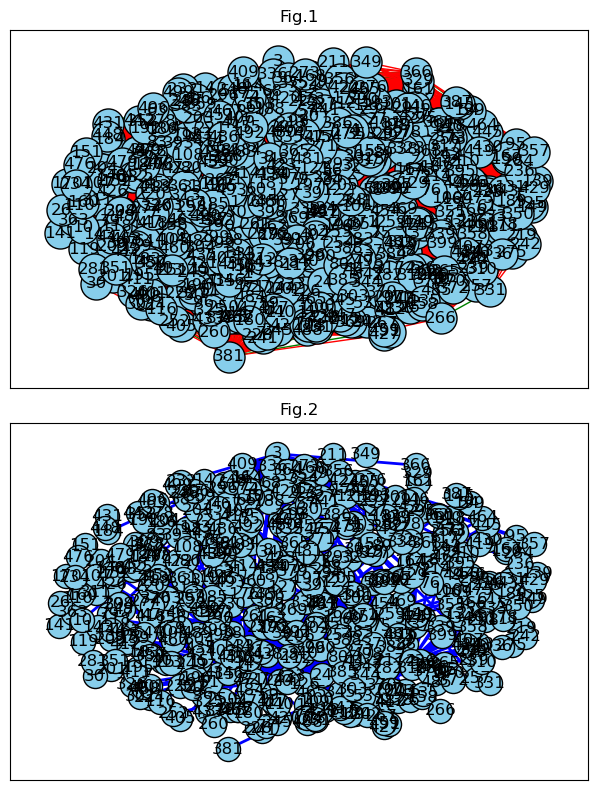

In [6]:
# # Create the graph
# file_path = fr"{os.getcwd()}/graph_test_files/test6.txt"
# # getting the vertex which has to be check for UDCS from user
# # Get input from the user
# input_string = input("Enter a vertex set values separated by spaces to check Def.Alli: ")

# # Split the input string into a list of values
# input_list = input_string.split()

# # Convert the list of strings to a list of integers (or floats, if desired)
# d = [int(x) for x in input_list]  # Use int() for integers, float() for floats
    
# k = int(input("Enter number of edges to flip: "))

# # start time recorded
# start_time = time.monotonic()

# # here graph means signed graph edge set. original_graph means same unsigned graph edge set.
# graph, original_graph  = read_signed_graph_from_file(file_path) 
# n = len(graph)
# case_type = "file_type"
# run_building_defensive_alliance(graph, original_graph, start_time, d, k, n, case_type)


#################################################################################

nodes_to_check = 500
p_plus = 0.1
p_minus = 0.2
# initial_avg_degree = 40
# p_plus = 0.1
max_nodes_to_check = int(input("Please enter maximum number of nodes wanted to check: "))

print("\nCase 1: Same Vertex set and Same number of flip value")
print("\nCase 2: Vertex set will increase by half of the previous set and number of flip value will increase by 1")
case = int(input("Please enter whcih case want to check: "))

d = [1,2,3,4,5,6,7,8,9,10]
k = 250

while(nodes_to_check <= max_nodes_to_check):
    
#     num_nodes = nodes_to_check
#     avg_degree = initial_avg_degree
#     G = erdos_renyi_signed_graph(num_nodes, avg_degree, p_plus)
    
    num_nodes = nodes_to_check    
    G = generate_random_signed_graph(num_nodes, p_plus, p_minus)
    graph, original_graph = create_graph_from_random_graph(G)
    start_time = time.monotonic()
    
#     print("\nNumber of Nodes are", num_nodes)
        
    if case == 1:
        case_type = "case1"
        run_building_defensive_alliance(graph, original_graph, start_time, d, k, num_nodes, case_type)
    else:
        case_type = "case2"
        
#         print("\nd ==> ", d)
#         print("\nk ==> ", k)
        run_building_defensive_alliance(graph, original_graph, start_time, d, k, num_nodes, case_type)
    
        d.append(d[-1]+1)
        k = k+300
    
    
#     initial_avg_degree = initial_avg_degree + 40
    nodes_to_check = nodes_to_check + 500